In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

boston = load_boston()

df = pd.DataFrame(data=boston.data, columns=boston.feature_names)

y = boston.target

In [2]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [3]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0)

X = df.copy()
rf.fit(X, y)

RandomForestRegressor(random_state=0)

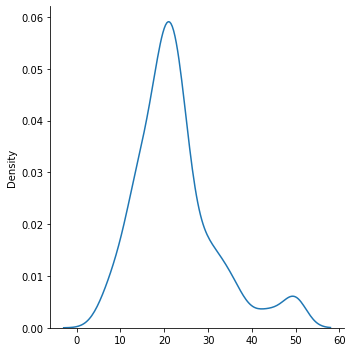

In [4]:
import seaborn as sns

sns.displot(x=y, kind='kde')

# 목적
y가 40이 되게 하는 X 값 찾기

## 임의의 row 생성

In [5]:
import random

def generate_feature(condition1, condition2):
        
    indivisual = []
    for col, value in condition1.items():
        if condition2[col] == 'float64':
            x = random.uniform(value['min'], value['max'])
        else:
            x = random.randint(value['min'], value['max'])
        indivisual.append(x)
    
    return indivisual

## 첫 세대 생성

In [6]:
def generate_population(size, condition1, condition2):
    population = []
    
    for i in range(size):
        indivisual = generate_feature(condition1, condition2)
        population.append(indivisual)
        
    return population

## fitness 측정

In [7]:
def fitness(model, indivisual, goal):
    y = np.array([indivisual]).reshape(1,-1)

    pred = model.predict(y)[0]
    
    score = abs(pred - goal)
    
    return score

## 점수를 오름차순 정렬(낮을 수록 좋음)

In [8]:
def compute_performance(model, population, goal=40):
    performance_list = []
    for indivisual in population:
        score = fitness(model, indivisual, goal)
        
        performance_list.append([indivisual, score])
    
    population_sorted = sorted(performance_list, key=lambda x:x[1], reverse=False)
    return population_sorted

## 살아남을 아이들을 선택

In [9]:
def select_survivors(population_sorted, best_sample, lucky_few):
    next_generation = []
    
    # best_sample 수만큼 다음 세대로 보냄
    for i in range(best_sample):
        next_generation.append(population_sorted[i][0])
    
    # 랜덤으로 운이 좋은 자식들을 살림
    lucky_survivors = random.sample(population_sorted, k=lucky_few)
    for I in lucky_survivors:
        next_generation.append(I[0])
        
    # 다음 세대의 자식들을 섞음
    random.shuffle(next_generation)
    
    return next_generation

## 아이들을 교배 및 돌연변이 생성

In [10]:
def create_child(indivisual1, indivisual2):
    child = []
    for i in range(len(indivisual1)):
        if random.random() < 0.5: # 50% 확률로 1의 유전자 획득
            child.append(indivisual1[i])
        else: # 50% 확률로 2의 유전자 획득
            child.append(indivisual2[i])
    return child

In [11]:
from scipy.stats import norm

# 정규분포에 따라 노이즈 추가
def mutate_feature(indivisual, condition1, condition2):
    indivisual = indivisual.copy()
    for i, (col, value) in enumerate(condition1.items()):
        rv = norm(value['mean'], value['std'])
        noise = rv.rvs(size=(1))[0]
        if condition2[col] == 'int64':
            noise = int(noise)
        
        indivisual[i] = noise
        if indivisual[i] > value['max']:
            indivisual[i] = value['max']
        
        if indivisual[i] < value['min']:
            indivisual[i] = value['min']
    return indivisual

# def mutate_population(population, chance_of_mutation, condition):
#     # chance_of_mutaion 만큼 돌연변이 생성
#     for i in range(len(population)):
#         if random.random() * 100 < chance_of_mutation:
#             population[i] = mutate_feature(population[i], condition)
#     return population

In [12]:
def create_children(parents, n_child, chance_of_mutation, condition1, condition2):
    # chance_of_mutaion 만큼 돌연변이 생성
    next_population = []
    for i in range(len(parents)//2):
        for j in range(n_child):
            child = create_child(parents[i], parents[-i-1])
            if random.random() * 100 < chance_of_mutation:
                child = mutate_feature(child, condition1, condition2)
            next_population.append(child)
    return next_population

## 유전 학습 시작

In [13]:
n_generation = 300
population = 100
goal = 40
best_sample = 20
lucky_few = 20
n_child = 5
chance_of_mutation = 10
tolerance = 0.2

In [15]:
def start_genetic_algorithm(data, model, n_generation, population, goal, best_sample, lucky_few, n_child, chance_of_mutation, tolerance):
    condition1 = data.describe().loc[['min', 'max', 'mean', 'std']].to_dict()
    condition2 = data.dtypes
    
    pop = generate_population(size=population, condition1=condition1, condition2=condition2)
    for g in range(n_generation):
        pop_sorted = compute_performance(model, population=pop, goal=goal)

        if pop_sorted[0][1] < tolerance: # 차이가 허용범위 이하면 찾음
            print("SUCESS! The score is", pop_sorted[0][1])
            break

        survivors = select_survivors(population_sorted=pop_sorted, best_sample=best_sample, lucky_few=lucky_few)

        new_generation = create_children(parents=survivors, n_child=n_child, 
                                         chance_of_mutation=chance_of_mutation, condition1=condition1, condition2=condition2)

#         new_generation = mutate_population(population=children, chance_of_mutation=chance_of_mutation, condition=condition)

        pop = new_generation

        print("==========%sth generation=========="%(g+1))
        print(pop_sorted[0][1])
    return pop_sorted[0][0]

In [16]:
best = start_genetic_algorithm(
    data=df,
    model=rf,
    n_generation=n_generation,
    population=population,
    goal=goal,
    best_sample=best_sample,
    lucky_few=lucky_few,
    n_child=n_child,
    chance_of_mutation=chance_of_mutation,
    tolerance=tolerance
)

SUCESS! The score is 0.11600000000000676


In [17]:
rf.predict([best])

array([40.116])

In [18]:
best = start_genetic_algorithm(
    data=df,
    model=rf,
    n_generation=n_generation,
    population=population,
    goal=50,
    best_sample=best_sample,
    lucky_few=lucky_few,
    n_child=n_child,
    chance_of_mutation=30,
    tolerance=0.5
)

==========1th generation==========
7.91999999999998
==========2th generation==========
7.073999999999998
==========3th generation==========
5.370999999999988
==========4th generation==========
3.9639999999999986
==========5th generation==========
3.735999999999997
==========6th generation==========
4.202999999999996
==========7th generation==========
2.1160000000000068
==========8th generation==========
2.8579999999999828
==========9th generation==========
2.148999999999994
==========10th generation==========
1.908999999999999
==========11th generation==========
1.5480000000000018
==========12th generation==========
1.5750000000000028
==========13th generation==========
1.3870000000000076
==========14th generation==========
1.2760000000000034
==========15th generation==========
1.1460000000000008
==========16th generation==========
1.1460000000000008
==========17th generation==========
0.8810000000000002
==========18th generation==========
0.8810000000000002
==========19th generation==

==========150th generation==========
0.6599999999999966
==========151th generation==========
0.6599999999999966
==========152th generation==========
0.6599999999999966
==========153th generation==========
0.6599999999999966
==========154th generation==========
0.6599999999999966
==========155th generation==========
0.6599999999999966
==========156th generation==========
0.6599999999999966
==========157th generation==========
0.6599999999999966
==========158th generation==========
0.6599999999999966
==========159th generation==========
0.6599999999999966
==========160th generation==========
0.6599999999999966
==========161th generation==========
0.6599999999999966
==========162th generation==========
0.6599999999999966
==========163th generation==========
0.6599999999999966
==========164th generation==========
0.6599999999999966
==========165th generation==========
0.6599999999999966
==========166th generation==========
0.6599999999999966
==========167th generation==========
0.659999999

==========297th generation==========
0.6599999999999966
==========298th generation==========
0.6599999999999966
==========299th generation==========
0.6599999999999966
==========300th generation==========
0.6599999999999966


In [19]:
rf.predict([best])

array([49.34])

# 자전거 수요 예측

In [20]:
df = pd.read_csv('bike.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [21]:
df['datetime'] = df.datetime.apply(pd.to_datetime)

df['year'] = df.datetime.apply(lambda x : x.year)
df['month'] = df.datetime.apply(lambda x : x.month)
df['day'] = df.datetime.apply(lambda x : x.day)
df['hour'] = df.datetime.apply(lambda x : x.hour)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [24]:
drop_columns = ['datetime', 'casual', 'registered']
df.drop(drop_columns, axis=1, inplace=True)

In [25]:
y_target = df['count']
X_features = df.drop(['count'], axis=1)

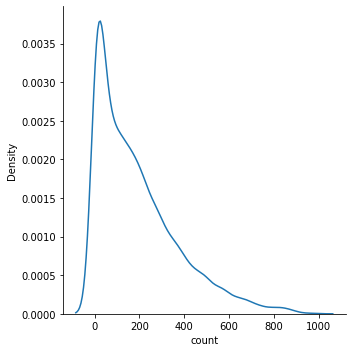

In [26]:
sns.displot(y_target, kind='kde')
plt.show()

In [27]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_features.values, y_target.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
goal = 800
tolerance = 5

best = start_genetic_algorithm(
    data=X_features,
    model=xgb,
    n_generation=n_generation,
    population=population,
    goal=goal,
    best_sample=best_sample,
    lucky_few=lucky_few,
    n_child=n_child,
    chance_of_mutation=chance_of_mutation,
    tolerance=tolerance
)

==========1th generation==========
178.007080078125
==========2th generation==========
192.25775146484375
==========3th generation==========
162.34588623046875
==========4th generation==========
34.93304443359375
==========5th generation==========
22.7984619140625
==========6th generation==========
13.44635009765625
SUCESS! The score is 4.13525390625


In [29]:
xgb.predict(np.array([best]))

array([795.86475], dtype=float32)

In [30]:
best

[4,
 0,
 1,
 1,
 26.67016916103666,
 31.32663781474915,
 56,
 8.450726845206827,
 2012,
 7,
 13,
 18]

In [31]:
goal = 1000
tolerance = 5

best = start_genetic_algorithm(
    data=X_features,
    model=xgb,
    n_generation=n_generation,
    population=population,
    goal=goal,
    best_sample=best_sample,
    lucky_few=lucky_few,
    n_child=n_child,
    chance_of_mutation=chance_of_mutation,
    tolerance=tolerance
)

==========1th generation==========
272.0118408203125
==========2th generation==========
334.4124755859375
==========3th generation==========
312.607177734375
==========4th generation==========
206.5186767578125
==========5th generation==========
169.142822265625
==========6th generation==========
29.63909912109375
==========7th generation==========
29.63909912109375
==========8th generation==========
54.58404541015625
==========9th generation==========
27.78753662109375
==========10th generation==========
27.78753662109375
==========11th generation==========
6.91619873046875
SUCESS! The score is 4.36663818359375


In [32]:
xgb.predict(np.array([best]))

array([1004.36664], dtype=float32)

In [33]:
best

[4,
 0,
 1,
 1,
 27.405788606710168,
 39.55158683909447,
 26,
 24.3603216655612,
 2012,
 9,
 11,
 17]

In [34]:
df.query("month == 9")

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
3602,3,0,1,1,24.60,28.790,78,7.0015,51,2011,9,1,0
3603,3,0,1,1,24.60,29.545,73,6.0032,21,2011,9,1,1
3604,3,0,1,1,23.78,27.275,78,6.0032,25,2011,9,1,2
3605,3,0,1,1,23.78,27.275,78,6.0032,14,2011,9,1,3
3606,3,0,1,1,22.96,26.515,83,6.0032,7,2011,9,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9514,3,0,1,1,22.96,26.515,43,15.0013,611,2012,9,19,19
9515,3,0,1,1,21.32,25.000,48,11.0014,409,2012,9,19,20
9516,3,0,1,1,20.50,24.240,59,11.0014,349,2012,9,19,21
9517,3,0,1,1,20.50,24.240,63,6.0032,229,2012,9,19,22
